# 1 Import & Install

In [1]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 26.1 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=17be2ece92c41a8b1aab22d300b237850f7b0245e74b74946938539462e6f120
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import re  # used for pattern matching and text manipulation.
import string 
import nltk 
from nltk.corpus import stopwords 
from nltk.stem import LancasterStemmer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder


2024-05-30 18:51:48.068027: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 18:51:48.068127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 18:51:48.192530: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 2 Load and Preview

In [3]:
# Paths for train and test data
train_path='/kaggle/input/nlp-final-exam/Genre Classification Dataset/train_data.txt'
test_path= '/kaggle/input/nlp-final-exam/Genre Classification Dataset/test_data_solution.txt'

# Load datasets with defined seperation between columns
train_data=pd.read_csv( train_path , sep=':::',engine='python',names=['Title','Genre','Description'])
test_data=pd.read_csv( test_path , sep=':::',engine='python',names=['Title','Genre','Description'])

# Preview datasets
print(train_data.head())
print(test_data.head())

                                Title       Genre  \
1       Oscar et la dame rose (2009)       drama    
2                       Cupid (1997)    thriller    
3   Young, Wild and Wonderful (1980)       adult    
4              The Secret Sin (1915)       drama    
5             The Unrecovered (2007)       drama    

                                         Description  
1   Listening in to a conversation between his do...  
2   A brother and sister with a past incestuous r...  
3   As the bus empties the students for their fie...  
4   To help their unemployed father make ends mee...  
5   The film's title refers not only to the un-re...  
                           Title          Genre  \
1          Edgar's Lunch (1998)       thriller    
2      La guerra de papá (1977)         comedy    
3   Off the Beaten Track (2010)    documentary    
4        Meu Amigo Hindu (2015)          drama    
5             Er nu zhai (1955)          drama    

                                         Des

# 3 Summary Statistics 

In [4]:
# Summary statistics for both train and test data
print(train_data.describe())
print(train_data.info())
print(test_data.describe())
print(test_data.info())

# Check for duplicate descriptions
description_counts_train = train_data['Description'].value_counts()
description_counts_test = test_data['Description'].value_counts()

# Find repeating descriptions
repeating_descriptions_train = description_counts_train[description_counts_train > 1]
repeating_descriptions_test = description_counts_test[description_counts_test > 1]

# Based on fined repeting description filter repeating descriptions
repeating_descriptions_df_train = train_data[train_data['Description'].isin(repeating_descriptions_train.index)].sort_values(by='Description')
repeating_descriptions_df_test = test_data[test_data['Description'].isin(repeating_descriptions_test.index)].sort_values(by='Description')

print(repeating_descriptions_df_train[['Title', 'Description']])
print(repeating_descriptions_df_test[['Title', 'Description']])


                                               Title    Genre  \
count                                          54214    54214   
unique                                         54214       27   
top      Nature's Fury: Storm of the Century (2006)    drama    
freq                                               1    13613   

                                              Description  
count                                               54214  
unique                                              54086  
top      Grammy - music award of the American academy ...  
freq                                                   12  
<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None
                     

### 3.1 Genre Distribution Plot

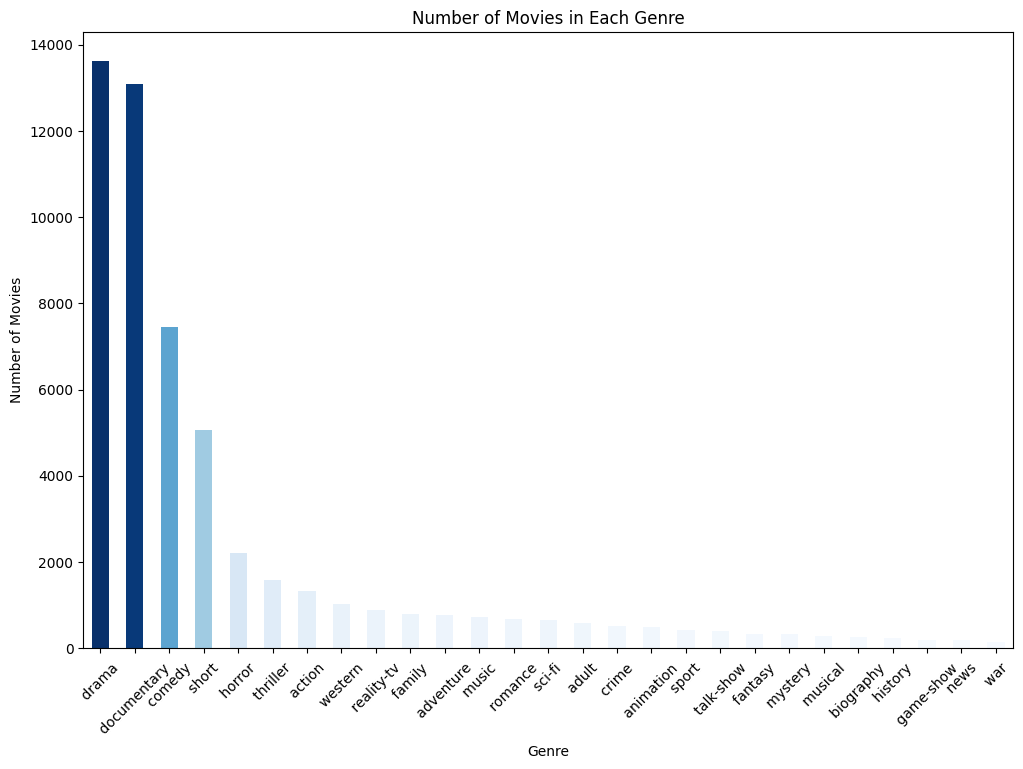

In [5]:
import matplotlib.colors as mcolors

# Plot the distribution of genres
# Calculating the count of each genre in the 'Genre' column of the train_data
genre_counts = train_data['Genre'].value_counts()
# Normalizing the genre counts to create a colormap range
norm = mcolors.Normalize(vmin=0.003*genre_counts.max(), vmax=genre_counts.max())
color_map = plt.get_cmap('Blues')
#Applying the colormap to the genre counts to generate corresponding colors
colors = [color_map(norm(count)) for count in genre_counts]

#Plotting genres
plt.figure(figsize=(12, 8))
genre_counts.plot(kind='bar', color=colors)
plt.title('Number of Movies in Each Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()


### 3.2 Description Length Distribution

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


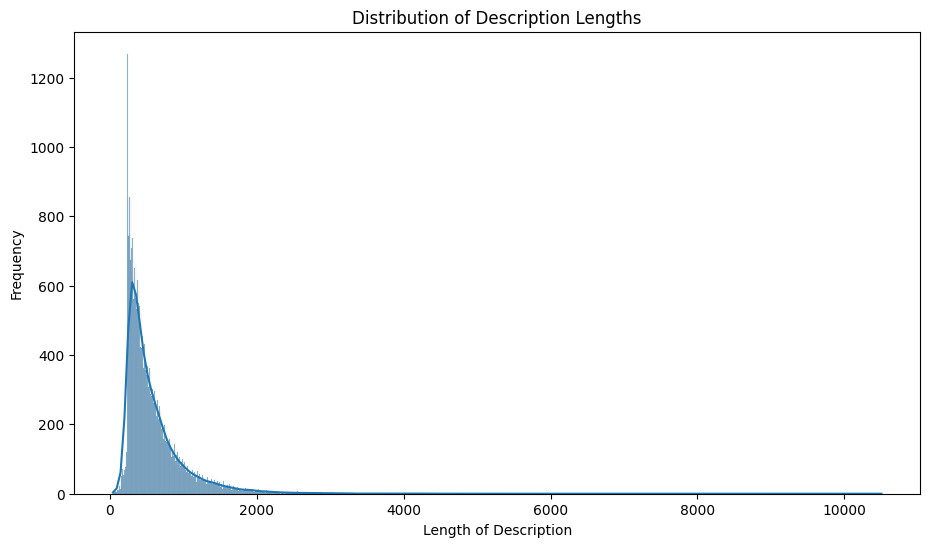

In [6]:
# Calculate description lengths in train data
train_data['Length'] = train_data['Description'].apply(len)

# Plot histogram of description lengths
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
sns.histplot(train_data['Length'], bins=2000, kde=True)
plt.title('Distribution of Description Lengths')
plt.xlabel('Length of Description')
plt.ylabel('Frequency')
plt.show()


# 4 Data Preprocessing

In [9]:
from langdetect import detect
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
# Remove duplicates
train_data.drop_duplicates(subset=['Description'], keep='first', inplace=True)
test_data.drop_duplicates(subset=['Description'], keep='first', inplace=True)

# Define the list of English stop words
stop_words = set(nltk.corpus.stopwords.words('english'))

# Define function to check if text is primarily in English
def english(text, threshold=0.6):
    words = nltk.word_tokenize(text.lower())
    english_word_count = sum(1 for word in words if word in stop_words or word.isalpha())
    english_ratio = english_word_count / len(words)
    return english_ratio >= threshold

# Filter non-English descriptions
train_data['is_english'] = train_data['Description'].apply(english)
test_data['is_english'] = test_data['Description'].apply(english)
train_data = train_data[train_data['is_english']].drop(columns=['is_english'])
test_data = test_data[test_data['is_english']].drop(columns=['is_english'])

# Clean text
stemmer = LancasterStemmer()
# Create function that clean text
def clean_text(text):
    # convert text to lower case,replace hyphens, remove digits, remove mentions,
    # remove non-letter caracters, remove urls,remove single caracters surranded by space
    text = text.lower()
    text = re.sub('-', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')
    # tokenize text into words
    words = word_tokenize(text)
    text = ' '.join([stemmer.stem(word) for word in words if word not in stop_words and len(word) > 2])
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply text cleaning on description column
train_data['Description_cleaning'] = train_data['Description'].apply(clean_text)
test_data['Description_cleaning'] = test_data['Description'].apply(clean_text)

# Remove short descriptions
train_data.loc[:, 'Length_Description_cleaning'] = train_data['Description_cleaning'].apply(len)
test_data.loc[:, 'Length_Description_cleaning'] = test_data['Description_cleaning'].apply(len)
train_data = train_data[train_data['Length_Description_cleaning'] >= 130]

# Give unique numeric value for each genre
le = LabelEncoder()
train_data['Genre_encoded'] = le.fit_transform(train_data['Genre'])
test_data['Genre_encoded'] = le.transform(test_data['Genre'])


# 5 BERT Model Training

### 5.1 Start Time

In [11]:
import time
# Start overall timing
start_time_bert = time.time()

### 5.2 Create Custom Callback Class for Monitoring

In [14]:
from transformers import TrainerCallback
class TrainValMetricsCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.steps = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
            if 'eval_loss' in logs:
                self.val_losses.append(logs['eval_loss'])
            if 'eval_accuracy' in logs:
                self.val_accuracies.append(logs['eval_accuracy'])
            if 'accuracy' in logs:  # Assuming 'accuracy' is the key for training accuracy
                self.train_accuracies.append(logs['accuracy'])
            if 'step' in logs:
                self.steps.append(logs['step'])


    def plot_metrics(self):
        plt.figure(figsize=(14, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.steps, self.train_losses, label='Training Loss')
        plt.plot(self.steps, self.val_losses, label='Validation Loss')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.title('Loss Over Steps')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.steps, self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Steps')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Over Steps')
        plt.legend()

        plt.show()

### 5.3 BERT Tokenizer

In [15]:
# Prepare data for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [16]:
# Create datasets
class TextDataset:
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [17]:
train_dataset = TextDataset(
    texts=train_data['Description_cleaning'].to_numpy(),
    labels=train_data['Genre_encoded'].to_numpy(),
    tokenizer=tokenizer,
    max_len=256
)

test_dataset = TextDataset(
    texts=test_data['Description_cleaning'].to_numpy(),
    labels=test_data['Genre_encoded'].to_numpy(),
    tokenizer=tokenizer,
    max_len=256
)

### 5.4 Load & Tune Pretrained Model

In [18]:
from transformers import Trainer, TrainingArguments, BertForSequenceClassification, TrainerCallback
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Load the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(train_data['Genre_encoded'].unique()))

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,  # Adjust batch size to use less memory
    per_device_eval_batch_size=16,
    warmup_steps=200,  # Adjust warmup steps for smaller model
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    save_steps=1200,
    evaluation_strategy="steps",
    eval_steps=600,  # Evaluate every 500 steps
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 5.6 Initializes Instance

In [31]:
# Define the compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
# Initialize the callback
train_val_metrics_callback = TrainValMetricsCallback()

In [20]:
# Define trainer with the custom callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,  # This is the validation dataset
    compute_metrics=compute_metrics,
    callbacks=[train_val_metrics_callback]
)


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


### 5.7 Train BERT Classifer Model

In [21]:
# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()



wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy
600,1.755200,1.720544,0.498658
1200,1.527400,1.539243,0.541775
1800,1.434900,1.462700,0.570823
2400,1.434600,1.400004,0.580376
3000,1.304700,1.389353,0.586059
3600,1.094200,1.357160,0.594335
4200,1.109500,1.360955,0.587004
4800,1.036100,1.319483,0.599870
5400,0.996700,1.311111,0.604980
6000,1.038600,1.297089,0.607572


{'eval_loss': 1.2926490306854248,
 'eval_accuracy': 0.6076645376284365,
 'eval_runtime': 539.5601,
 'eval_samples_per_second': 100.109,
 'eval_steps_per_second': 6.257,
 'epoch': 2.0}

### 5.8 Get Predictions

In [22]:
# Get predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)


In [23]:
# Get predictions
predictions_train = trainer.predict(train_dataset)
preds_train = np.argmax(predictions_train.predictions, axis=1)

In [ ]:
# Capture the end time
end_time_bert = time.time()

# Calculate the overall running time
overall_time_bert = end_time_bert - start_time_bert

# Print the overall running time
print(f"Total running time: {overall_time_bert:.2f} seconds.")


### 5.9 Clasification Report

In [39]:
# Define label names
label_names = le.inverse_transform(np.arange(len(le.classes_)))

# Calculate accuracy
accuracy = accuracy_score(test_dataset.labels, preds)
print(f'Accuracy: {accuracy}')

# Generate classification report with zero_division parameter
report = classification_report(test_dataset.labels, preds, target_names=label_names, zero_division=0)
print(report)


Accuracy: 0.6076645376284365
               precision    recall  f1-score   support

      action        0.43      0.46      0.44      1313
       adult        0.51      0.51      0.51       589
   adventure        0.36      0.24      0.29       772
   animation        0.35      0.19      0.24       496
   biography        0.00      0.00      0.00       263
      comedy        0.60      0.58      0.59      7426
       crime        0.22      0.02      0.04       505
 documentary        0.73      0.82      0.77     13072
       drama        0.59      0.74      0.66     13555
      family        0.35      0.20      0.26       770
     fantasy        0.30      0.12      0.18       321
   game-show        0.82      0.65      0.72       191
     history        0.00      0.00      0.00       243
      horror        0.58      0.70      0.63      2199
       music        0.58      0.61      0.60       712
     musical        0.22      0.05      0.08       273
     mystery        0.00      0.00 

### 5.11 Confusion Matrix Test Data

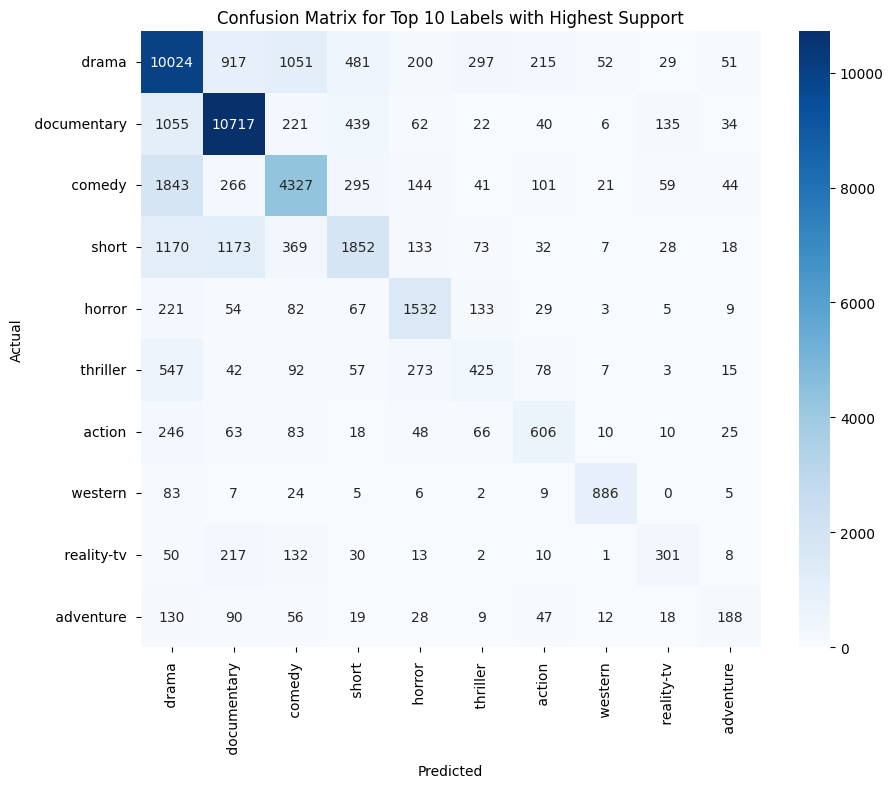

In [33]:
# Import the confusion_matrix function
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Generate confusion matrix for all labels
cm = confusion_matrix(test_dataset.labels, preds)

# Calculate support for each label in the test set
support = np.bincount(test_dataset.labels)

# Get the indices of the top 10 labels with the highest support
top_10_labels_indices = np.argsort(support)[-10:][::-1]

# Filter the confusion matrix to include only the top 10 labels
filtered_cm = cm[top_10_labels_indices][:, top_10_labels_indices]

# Get the names of the top 10 labels
top_10_label_names = le.inverse_transform(top_10_labels_indices)

# Plot the filtered confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_cm, annot=True, fmt='d', cmap='Blues', xticklabels=top_10_label_names, yticklabels=top_10_label_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Top 10 Labels with Highest Support')
plt.show()

In [34]:
# Calculate accuracy
accuracy = accuracy_score(train_dataset.labels, preds_train)
print(f'Accuracy: {accuracy}')

# Generate classification report
report = classification_report(train_dataset.labels, preds_train, target_names=label_names)
print(report)

Accuracy: 0.7592123603667276
               precision    recall  f1-score   support

      action        0.63      0.65      0.64      1238
       adult        0.74      0.76      0.75       544
   adventure        0.64      0.42      0.51       736
   animation        0.56      0.36      0.44       474
   biography        0.00      0.00      0.00       258
      comedy        0.80      0.79      0.79      6926
       crime        0.54      0.06      0.11       470
 documentary        0.84      0.92      0.88     12590
       drama        0.73      0.87      0.79     12718
      family        0.60      0.37      0.46       733
     fantasy        0.57      0.28      0.37       298
   game-show        0.89      0.81      0.85       183
     history        0.43      0.01      0.03       231
      horror        0.74      0.89      0.81      2056
       music        0.75      0.79      0.77       673
     musical        0.64      0.20      0.31       262
     mystery        0.00      0.00 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5.12 Confusion Matrix Train Data

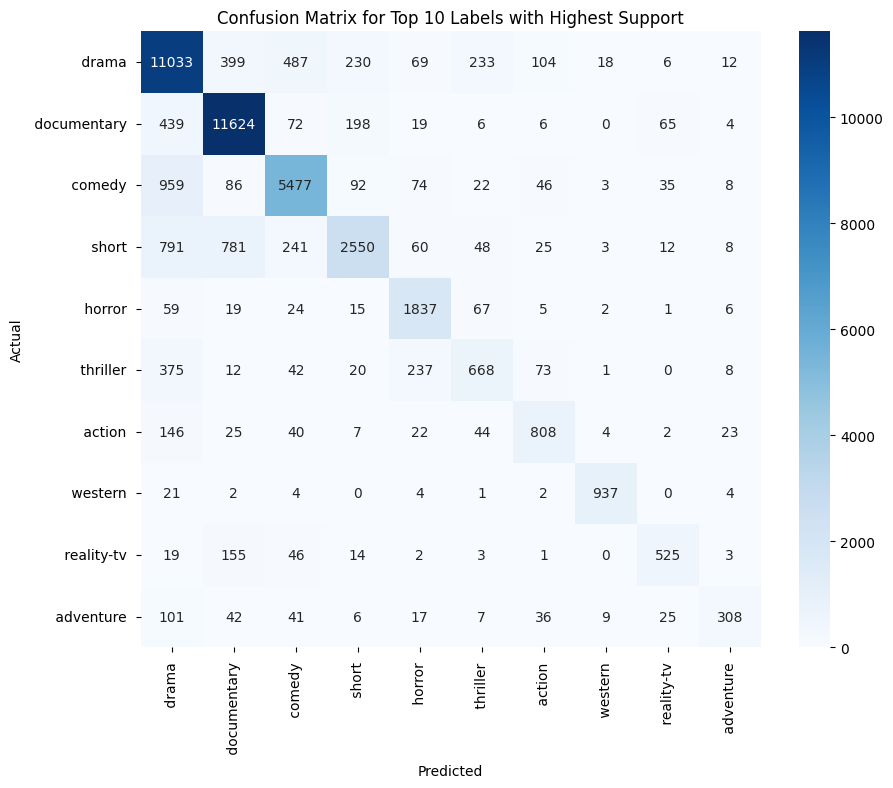

In [35]:
# Generate confusion matrix for all labels
cm = confusion_matrix(train_dataset.labels, preds_train)

# Calculate support for each label in the test set
support = np.bincount(train_dataset.labels)

# Get the indices of the top 10 labels with the highest support
top_10_labels_indices = np.argsort(support)[-10:][::-1]

# Filter the confusion matrix to include only the top 10 labels
filtered_cm = cm[top_10_labels_indices][:, top_10_labels_indices]

# Get the names of the top 10 labels
top_10_label_names = le.inverse_transform(top_10_labels_indices)

# Plot the filtered confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_cm, annot=True, fmt='d', cmap='Blues', xticklabels=top_10_label_names, yticklabels=top_10_label_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Top 10 Labels with Highest Support')
plt.show()

In [36]:
# Track the training metrics
history = trainer.state.log_history

In [40]:

# Extract accuracy and loss values for plotting
acc = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]
val_acc = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Ensure that epochs is the same length as acc, val_acc, loss, and val_loss
epochs = range(len(acc))

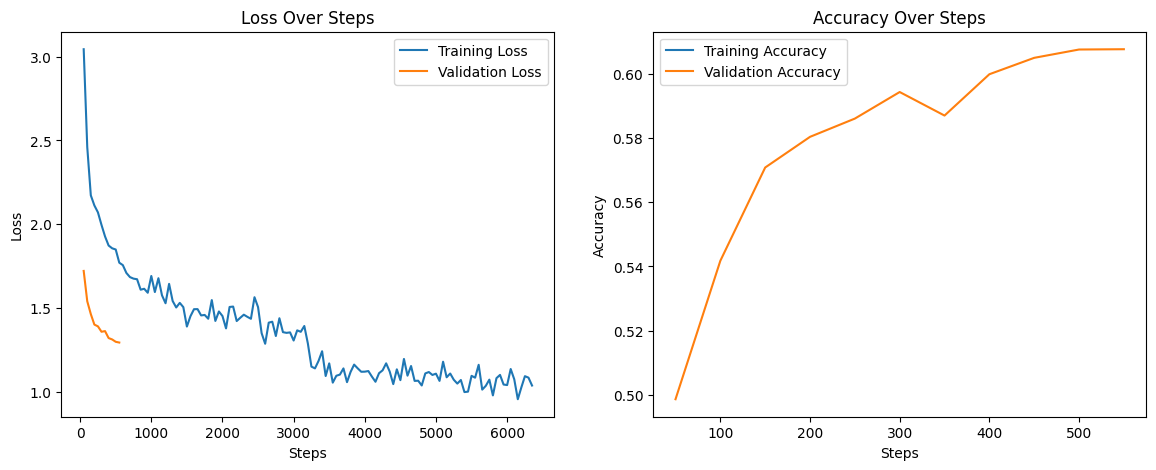

In [38]:
# Extract the log history
log_history = trainer.state.log_history

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
steps = []

# Process the log history
for log in log_history:
    if 'loss' in log:
        train_losses.append(log['loss'])
        steps.append(log['step'])
    if 'eval_loss' in log:
        val_losses.append(log['eval_loss'])
    if 'eval_accuracy' in log:
        val_accuracies.append(log['eval_accuracy'])

# Plot the training and validation loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(steps[:len(train_losses)], train_losses, label='Training Loss')
plt.plot(steps[:len(val_losses)], val_losses, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss Over Steps')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(steps[:len(train_accuracies)], train_accuracies, label='Training Accuracy')
plt.plot(steps[:len(val_accuracies)], val_accuracies, label='Validation Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Steps')
plt.legend()

plt.show()


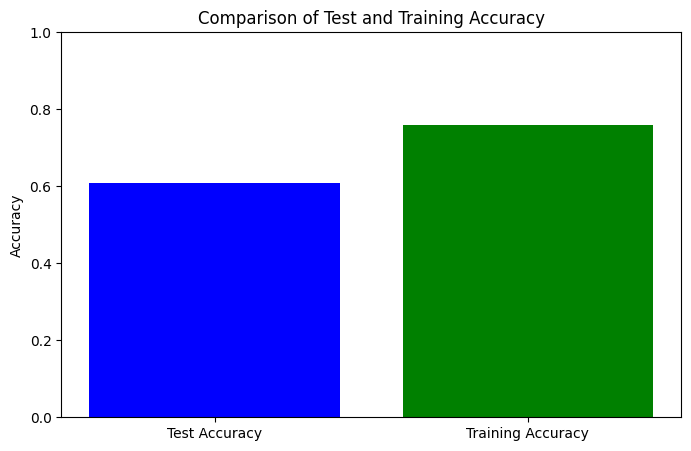

In [42]:
# Get predictions for training data
predictions_train = trainer.predict(train_dataset)
y_train_pred = np.argmax(predictions_train.predictions, axis=1)

# Calculate accuracy for training data
train_accuracy = accuracy_score(train_dataset.labels, y_train_pred)

# Bar chart to compare both accuracies
labels = ['Test Accuracy', 'Training Accuracy']
accuracies = [accuracy_score(test_dataset.labels, preds), train_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracies, color=['blue', 'green'])
plt.ylabel('Accuracy')
plt.title('Comparison of Test and Training Accuracy')
plt.ylim(0, 1)
plt.show()